In [4]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.preprocessing import LabelEncoder

from numpy import loadtxt
#from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')


In [5]:
raw_data = pd.read_csv('train.csv')
raw_data.loc[raw_data['voted']==2, 'voted']=0
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    raw_data[flip] = 6 - raw_data[flip]

flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    raw_data[flip] = 6 - raw_data[flip]

raw_data['Mach_score'] = raw_data[Answers].sum(axis = 1)
raw_data.drop(['index'], axis=1, inplace=True)
data = raw_data.copy()


In [6]:
index1 = data.loc[data['familysize'] >= 50].index 
data1 = data.drop(index1, axis=0)                        # 50명이상 삭제

data2 = data.copy()
data2.loc[data2['familysize'] >= 5, 'familysize'] = 5    # 5명이상은 5명이상 범주로

data3 = data.copy()
data3.loc[data3['familysize'] >= 10, 'familysize'] = 10  # 10명이상은 10명이상 범주로

index2 = data.loc[data['familysize'] >= 10].index
data4 = data.drop(index2, axis=0)                        # 10명이상 삭제

index3 = data.loc[data['familysize'] >= 6].index
data5 = data.drop(index3, axis=0)                        # 6명이상 삭제

#data_list = [data, data1, data2, data3, data4, data5]
data = data5
data.shape

(43795, 78)

아래는 최종 중요 변수별 투표 여부 파악  +  투표/미투표 비율 높은 그룹에 대한 히스토그램 시각화


In [8]:
index1 = data.loc[ (data['age_group'] == '20s') & (data['Mach_score'] >= 70)
 & (data['education'] == 1) & ( (data['religion'] == 'Atheist') | (data['religion'] == 'Muslim') )].index

index2 = data.loc[ (data['age_group'] == '60s') & (data['Mach_score'] < 50)
 & (data['education'] == 4) & (data['religion'] == 'Christian_Protestant')].index

group1 = data.loc[index1, :]
group2 = data.loc[index2, :]


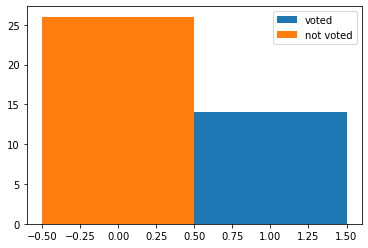

In [9]:
plt.hist( group1.loc[ group1['voted'] == 1]['voted'], label='voted', bins=1)
plt.hist( group1.loc[ group1['voted'] == 0]['voted'], label='not voted', bins=1)
plt.legend()

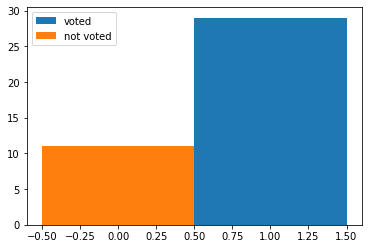

In [10]:
plt.hist( group2.loc[ group2['voted'] == 1]['voted'], label='voted', bins=1)
plt.hist( group2.loc[ group2['voted'] == 0]['voted'], label='not voted', bins=1)
plt.legend()

아래부터는 인코딩 및 모델링

In [11]:
cate_features = ['age_group', 'education', 'engnat', 'hand', 'married', 'race', 'urban', 'religion', 'familysize']
cate_features2 = ['tp01', 'tp02', 'tp03', 'tp04', 'tp05','tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'wf_01','wf_02', 'wf_03', 
                'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06','wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

for c in cate_features:
    target_encode=data.groupby(c)['voted'].mean()
    data[c]=data[c].map(target_encode)

#for c in cate_features2:
#    target_encode=data.groupby(c)['voted'].mean()
#    data[c]=data[c].map(target_encode)


label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])

train = data.drop('voted', axis=1)
drop_list = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE',
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE',
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE']
d2 = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA',
       'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

train = train.drop(drop_list, axis=1)
train = train.drop(d2, axis=1)


target = data['voted']

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.25, random_state=42, stratify=target)
print(x_train.shape, x_test.shape)

(32846, 37) (10949, 37)


In [13]:

# plot feature importance manually




def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

model = XGBClassifier(    
    learning_rate =0.005,
    max_depth=6,
    min_child_weight=15,
    gamma=0.10,
    subsample=0.7,
    colsample_bytree=0.7,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=2019)
model.fit(x_train, y_train)

[16:20:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=6,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, nthread=-1, num_parallel_tree=1,
              predictor='auto', random_state=2019, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=2019, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [14]:

def get_clf_eval(y_test, y_pred):
    print("[XGBOOST]")
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

pred = model.predict(x_test)
#print(pred)
get_clf_eval(y_test, pred)

[XGBOOST]
오차행렬:
 [[4035 1964]
 [1298 3652]]

정확도: 0.7021
정밀도: 0.6503
재현율: 0.7378
F1: 0.6913
AUC: 0.7052


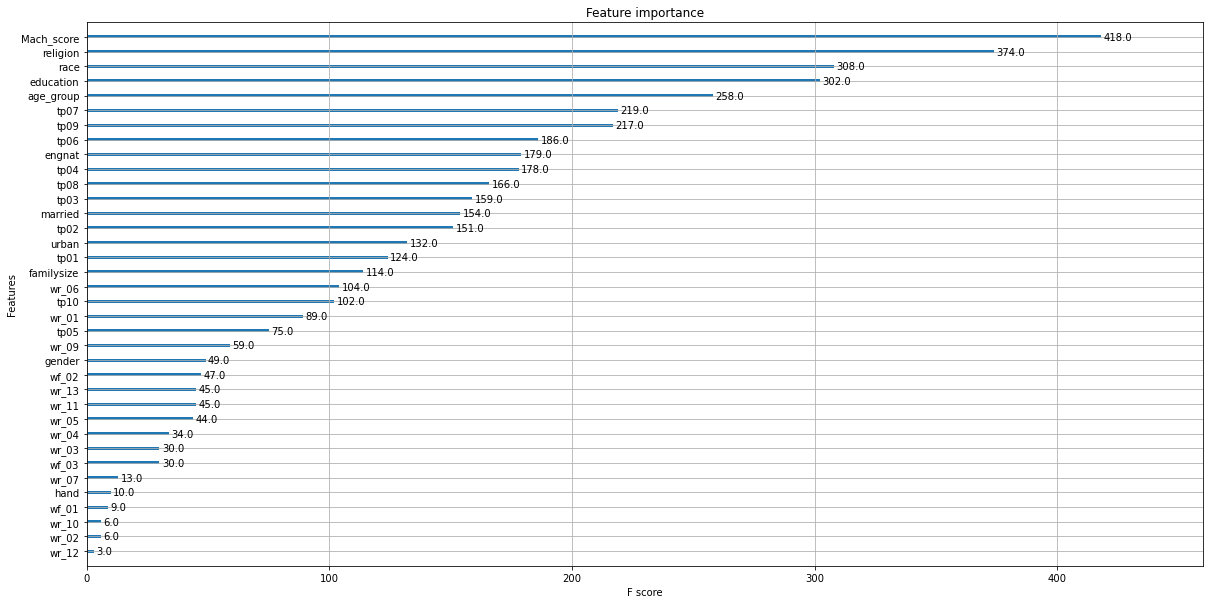

In [15]:
#print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 10)


아래는 XGB 하이퍼 파라미터 튜닝


그리드 서치 + 런타임 너무 긴 이슈로 몇가지 하이퍼파라미터는 수동으로 나눠서 테스트

In [ ]:
target = 'voted'
IDcol = 'Unnamed: 0'


predictors = [x for x in data.columns if x not in [target, IDcol]]
data.loc[data['voted']==2, 'voted']=0

In [ ]:
param_test1 = {                     #하이퍼 파라미터가 너무 많아 실제로는 나눠서 진행
 'max_depth':range(6,10,1),        
 'min_child_weight':range(0,30,3),
 'gamma':[i/10.0 for i in range(0, 15, 1)],                
 'subsample':[i/10.0 for i in range(7,9)],             
 'colsample_bytree':[i/10.0 for i in range(7, 9)],     
 'reg_alpha':[1e-2, 0.1, 1]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.005, 
                                                  n_estimators=1000, 
                                                  max_depth=6,         
                                                  min_child_weight=50,  
                                                  gamma=0, 
                                                  subsample=0.7, 
                                                  colsample_bytree=0.7,
                                                  reg_alpha = 0.1, 
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  eval_metric = 'error',
                                                  seed=2019), 
                        param_grid = param_test1, scoring='accuracy', n_jobs=-1, cv=5, verbose=10)
gsearch1.fit(data[predictors],data[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

